In [1]:
%reload_ext watermark
%watermark -a "Hugo Mendes"

Author: Hugo Mendes



# Houses Prediction

## Objetivo: Gerar um modelo de previsão a partir do dataset escolhido Kaggle para inferir novos valores para casas que serão passadas pela aplicação de API do projeto.
## Etapas: Vamos utilizar de todas as etapas de um projeto Data Science (Carregando dos dados, Conhecimento dos dados, Análise Exploratória, Limpeza e Pré Processamento, Geração do Modelo, Validações e Avaliações, Importar o modelo para o deploy (produção).
## Metas: Pretendo alcançar um modelo de previsão com o poder de explicabilidade maior que 85% e que o modelo seja estatisticamente significativo e também que minimizamos ao máximo o MAE (erro absoluto médio) e RMSE (raiz do erro quadrático médio).

### 1. Importação das Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [3]:
# versões dos pacotes
%watermark --iversions

matplotlib: 3.10.7
numpy     : 2.3.5
pandas    : 2.3.3
scipy     : 1.16.3
seaborn   : 0.13.2
sklearn   : 1.8.0



### 2. Carregando os dados

In [4]:
dataset = "Housing.csv"
df_casas = pd.read_csv(dataset, sep=",")

In [5]:
# Exibindo linhas inicias do DataFrame
df_casas.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [6]:
# Exibindo linhas finais do Dataframe
df_casas.tail()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished
544,1750000,3850,3,1,2,yes,no,no,no,no,0,no,unfurnished


### 3. Conhecendo os dados

In [7]:
# Informações do Dataframe
df_casas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [8]:
# Quantidade de atributos (colunas)
len(df_casas.columns)

13

In [9]:
# Quantidade de linhas
df_casas.shape[0]

545

In [10]:
# Quantidade de registros
df_casas.shape[0] * df_casas.shape[1]

7085

In [11]:
# Tipos de dados
df_casas.dtypes

price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

In [12]:
df_casas.select_dtypes(include=np.number).columns # Colunas numéricas

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking'], dtype='object')

In [13]:
df_casas.select_dtypes(include="object").columns # Colunas categoricas

Index(['mainroad', 'guestroom', 'basement', 'hotwaterheating',
       'airconditioning', 'prefarea', 'furnishingstatus'],
      dtype='object')

### 4. Análise Exploratória

In [14]:
# Valores ausentes
df_casas.loc[df_casas.isnull().any(axis=1)]

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus


In [15]:
df_casas.isnull().sum().sum()

np.int64(0)

In [16]:
# Linhas duplicadas
df_casas[df_casas.duplicated()]

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus


In [17]:
df_casas[df_casas.duplicated(subset=df_casas.drop(columns="price").columns, keep=False)].sort_values(by="area", ascending=False)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
435,3290000,4040,2,1,1,yes,no,no,no,no,0,no,unfurnished
414,3423000,4040,2,1,1,yes,no,no,no,no,0,no,unfurnished
408,3430000,4000,2,1,1,yes,no,no,no,no,0,no,unfurnished
496,2695000,4000,2,1,1,yes,no,no,no,no,0,no,unfurnished
544,1750000,3850,3,1,2,yes,no,no,no,no,0,no,unfurnished
458,3115000,3850,3,1,2,yes,no,no,no,no,0,no,unfurnished
385,3570000,3640,2,1,1,yes,no,no,no,no,0,no,unfurnished
525,2345000,3640,2,1,1,yes,no,no,no,no,0,no,unfurnished
411,3430000,2145,3,1,3,yes,no,no,no,no,0,yes,furnished
407,3465000,2145,3,1,3,yes,no,no,no,no,0,yes,furnished


In [18]:
media_casa_1 = np.mean(df_casas.loc[[408,496], "price"]) # média do preço
df_casas.loc[408, "price"] = media_casa_1 # substituindo pela média
df_casas.drop(496, axis=0, inplace=True) # removendo a outra linha

In [19]:
media_casa_2 = np.mean(df_casas.loc[[458,544], "price"])
df_casas.loc[458, "price"] = media_casa_2
df_casas.drop(544, axis=0, inplace=True) 

In [20]:
media_casa_3 = np.mean(df_casas.loc[[385,525], "price"])
df_casas.loc[385, "price"] = media_casa_3
df_casas.drop(525, axis=0, inplace=True) 

In [21]:
df_casas[df_casas.duplicated(subset=df_casas.drop(columns="price").columns, keep=False)].sort_values(by="area", ascending=False)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
435,3290000,4040,2,1,1,yes,no,no,no,no,0,no,unfurnished
414,3423000,4040,2,1,1,yes,no,no,no,no,0,no,unfurnished
411,3430000,2145,3,1,3,yes,no,no,no,no,0,yes,furnished
407,3465000,2145,3,1,3,yes,no,no,no,no,0,yes,furnished
427,3332000,2145,3,1,2,yes,no,yes,no,no,0,yes,furnished
436,3290000,2145,3,1,2,yes,no,yes,no,no,0,yes,furnished


In [22]:
# Medidas estatisticas nas colunas numéricas
df_casas.describe(include=np.number)

,price,area,bedrooms,bathrooms,stories,parking
count,5.420000e+02,542.000000,542.000000,542.000000,542.000000,542.000000
mean,4.777518e+06,5157.850554,2.968635,1.287823,1.808118,0.697417
std,1.868885e+06,2173.886659,0.737768,0.503407,0.868470,0.862418
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.465000e+06,3588.000000,2.250000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.766250e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [23]:
# Medidas estatisticas nas colunas categoricas
df_casas.describe(include="object")

,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus
count,542,542,542,542,542,542,542
unique,2,2,2,2,2,2,3
top,yes,no,no,no,no,no,semi-furnished
freq,465,445,351,517,370,414,227


In [24]:
# Calculando o coeficiente de variação das variáveis numéricas
for column in df_casas.select_dtypes(include=np.number).columns:
    cv = (df_casas[column].std() / df_casas[column].mean()) * 100
    print(f"A variável {column} tem um coeficiente de variação de {cv:.2f}%")

A variável price tem um coeficiente de variação de 39.12%
A variável area tem um coeficiente de variação de 42.15%
A variável bedrooms tem um coeficiente de variação de 24.85%
A variável bathrooms tem um coeficiente de variação de 39.09%
A variável stories tem um coeficiente de variação de 48.03%
A variável parking tem um coeficiente de variação de 123.66%


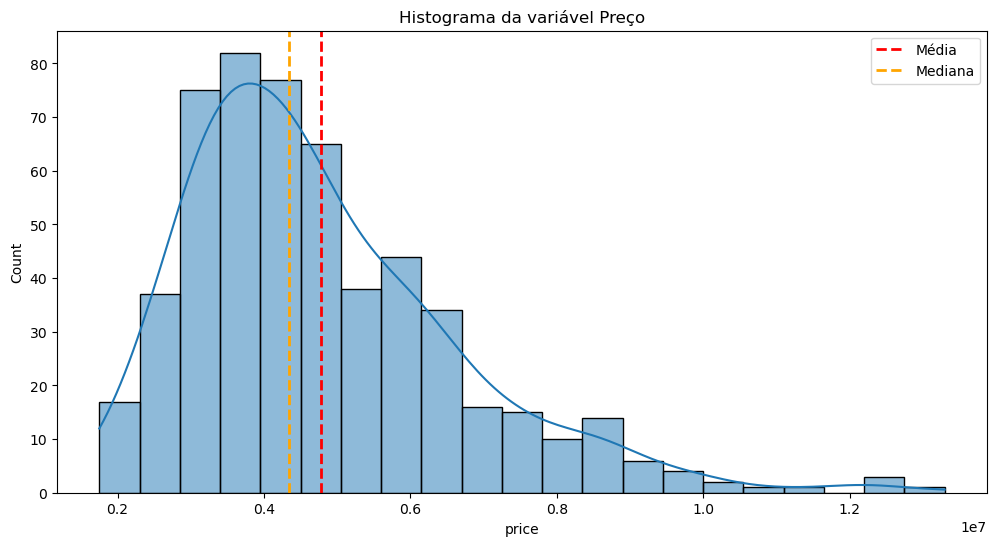

In [25]:
# Distribuição dos atributos
plt.figure(figsize=(12,6))
sns.histplot(df_casas["price"], kde=True)
plt.axvline(df_casas["price"].mean(), color = "red", linestyle = '--', linewidth = 2, label = f"Média")
plt.axvline(df_casas["price"].median(), color = "orange", linestyle = '--', linewidth = 2, label = f"Mediana")
plt.title("Histograma da variável Preço")
plt.legend()
plt.show()

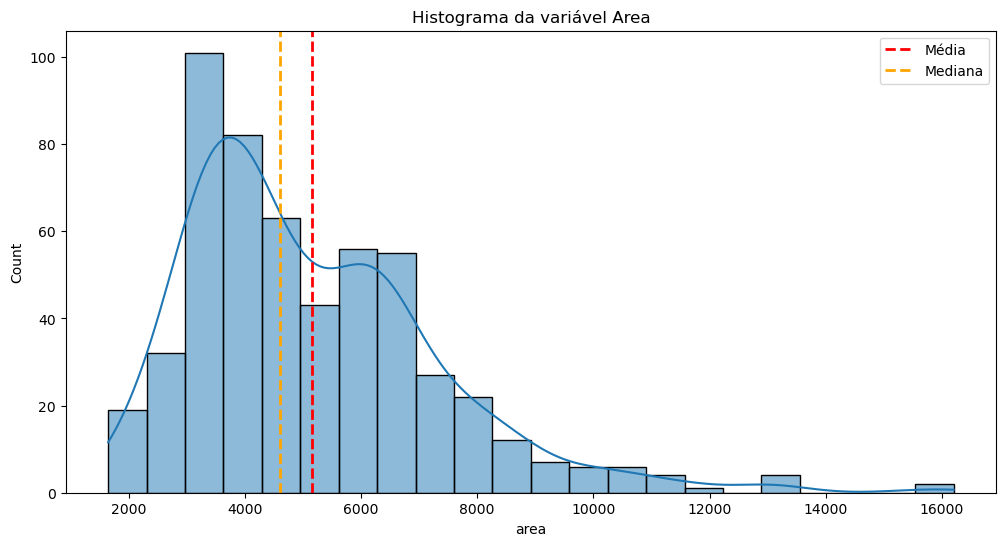

In [26]:
plt.figure(figsize=(12,6))
sns.histplot(df_casas["area"], kde=True)
plt.axvline(df_casas["area"].mean(), color = "red", linestyle = '--', linewidth = 2, label = f"Média")
plt.axvline(df_casas["area"].median(), color = "orange", linestyle = '--', linewidth = 2, label = f"Mediana")
plt.legend()
plt.title("Histograma da variável Area")
plt.show()

In [27]:
colunas_distribuicao = [
    "bedrooms", "bathrooms", "stories", "parking", 
    "mainroad", "guestroom", "basement", "hotwaterheating",
    "airconditioning", "prefarea", "furnishingstatus"
]

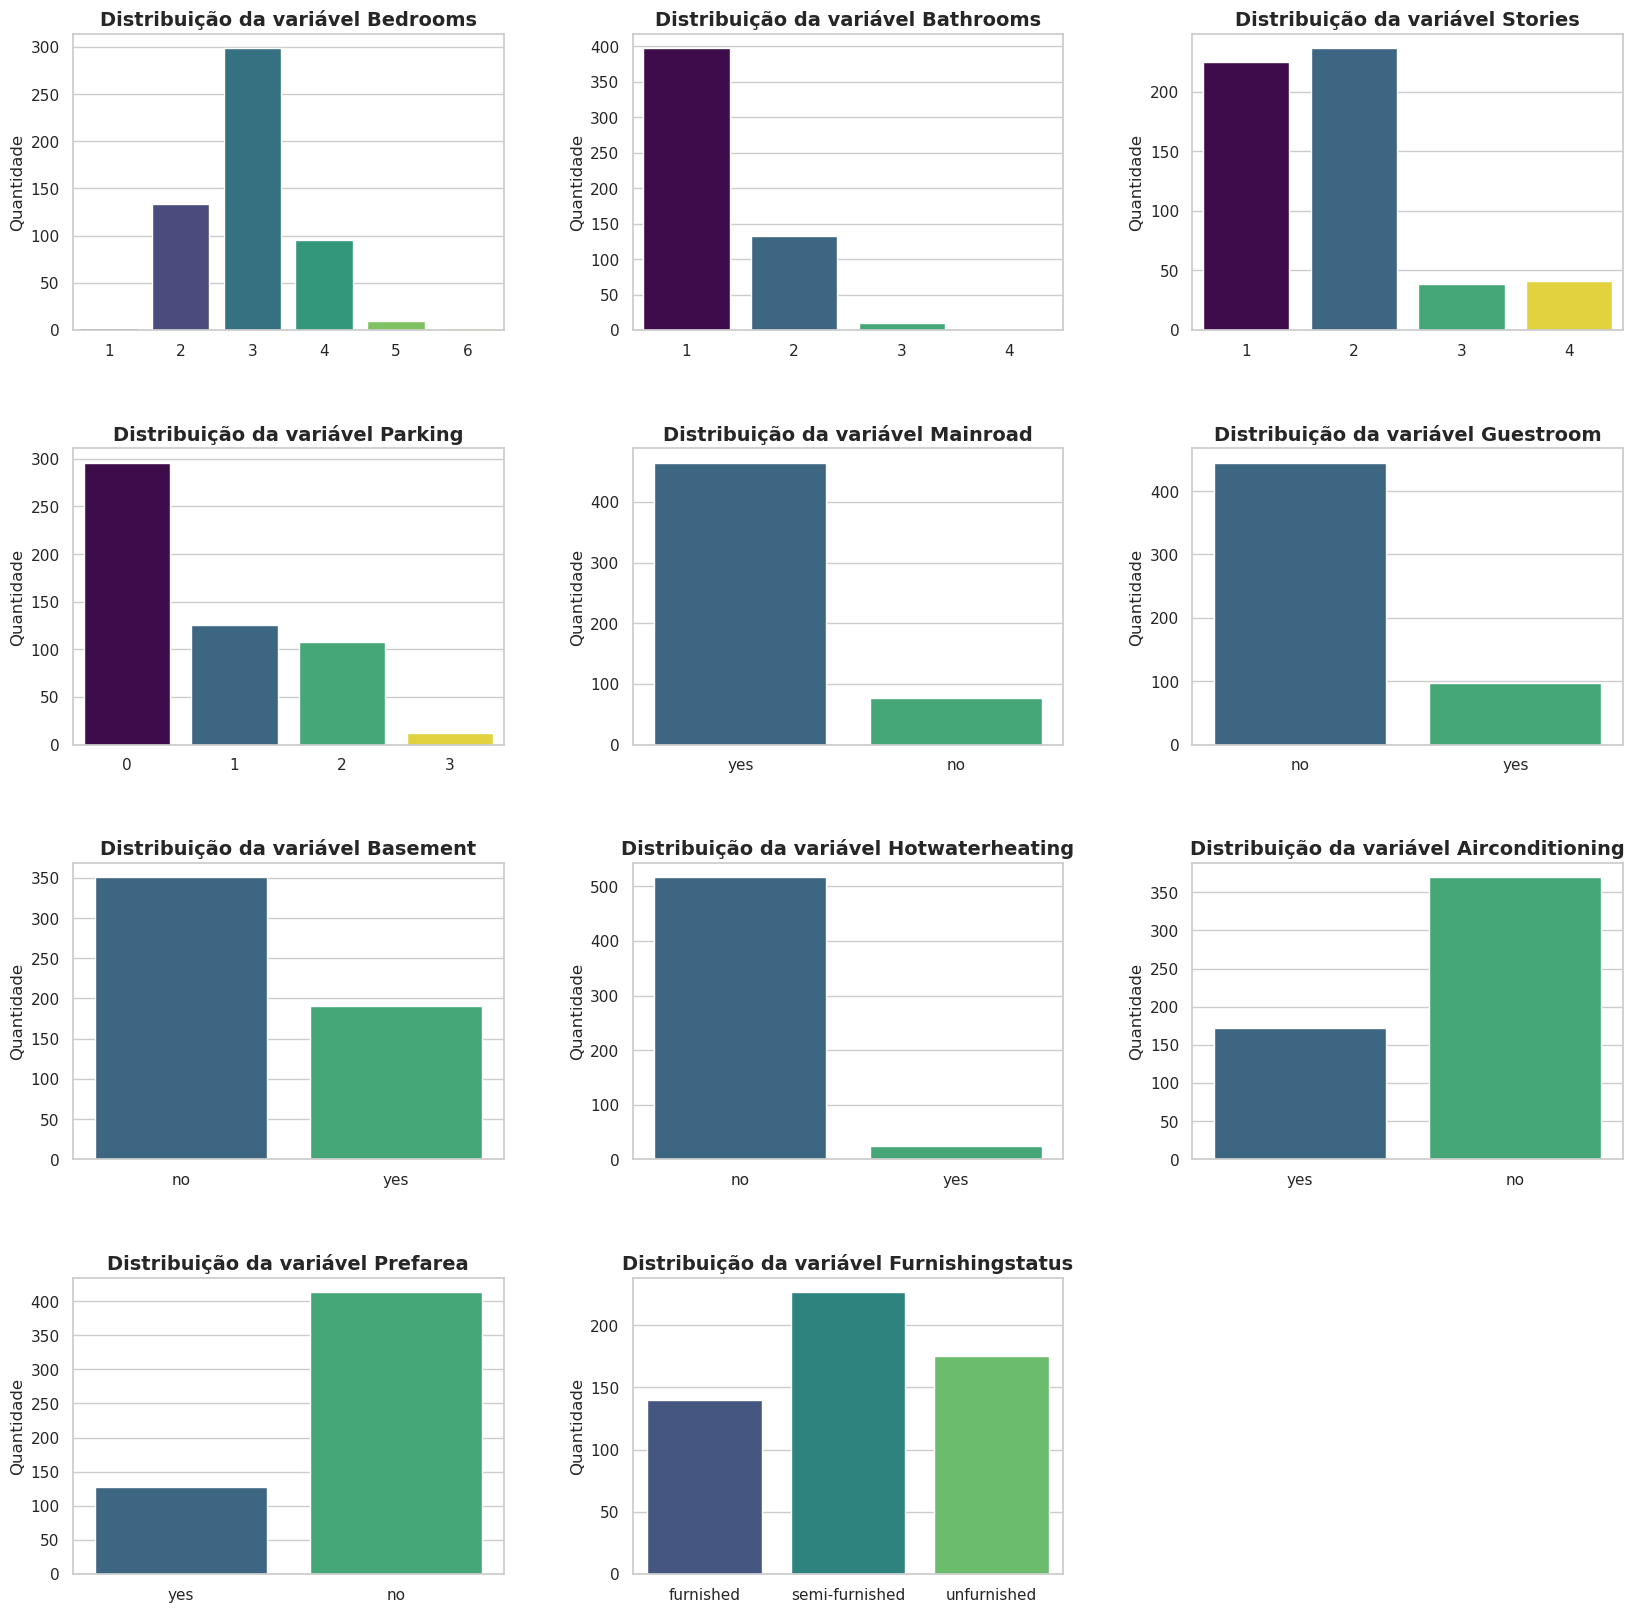

In [28]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
for i, coluna in enumerate(colunas_distribuicao):
    plt.subplot(4, 3, i + 1) # Cria o grid 4x3
    
    # Criando o countplot
    ax = sns.countplot(data=df_casas, x=coluna, palette="viridis", hue=coluna, legend=False)
    
    # Customização de cada gráfico
    plt.title(f"Distribuição da variável {coluna.capitalize()}", fontsize=14, fontweight="bold")
    plt.xlabel("") 
    plt.ylabel("Quantidade")
plt.show()

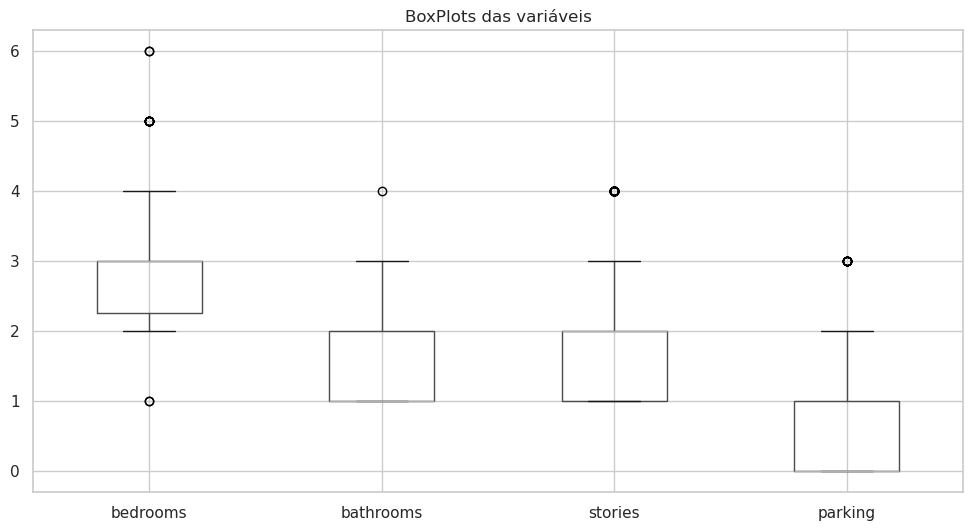

In [29]:
# Detecção de outliers
df_casas.drop(columns=["price","area"]).select_dtypes(include=np.number).boxplot(figsize=(12,6))
plt.title("BoxPlots das variáveis")
plt.show()

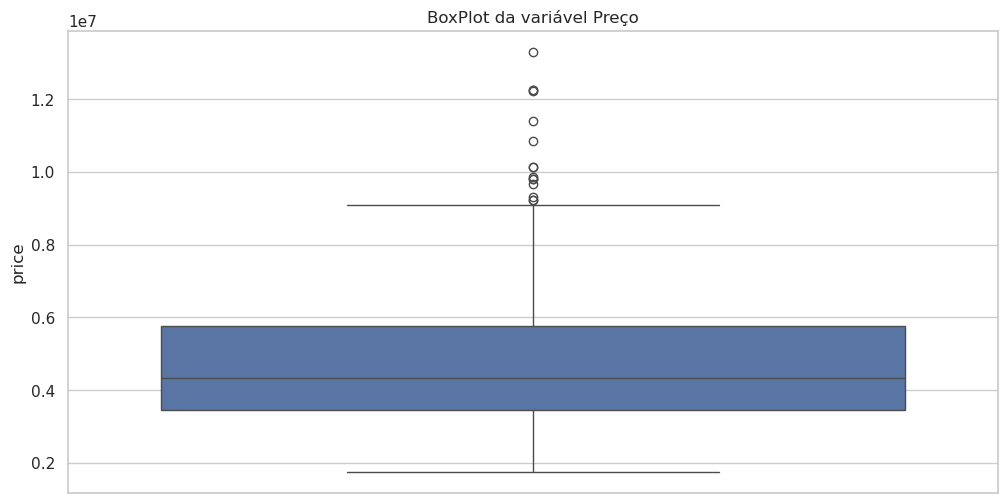

In [30]:
plt.figure(figsize=(12,6))
sns.boxplot(df_casas["price"])
plt.title("BoxPlot da variável Preço")
plt.show()

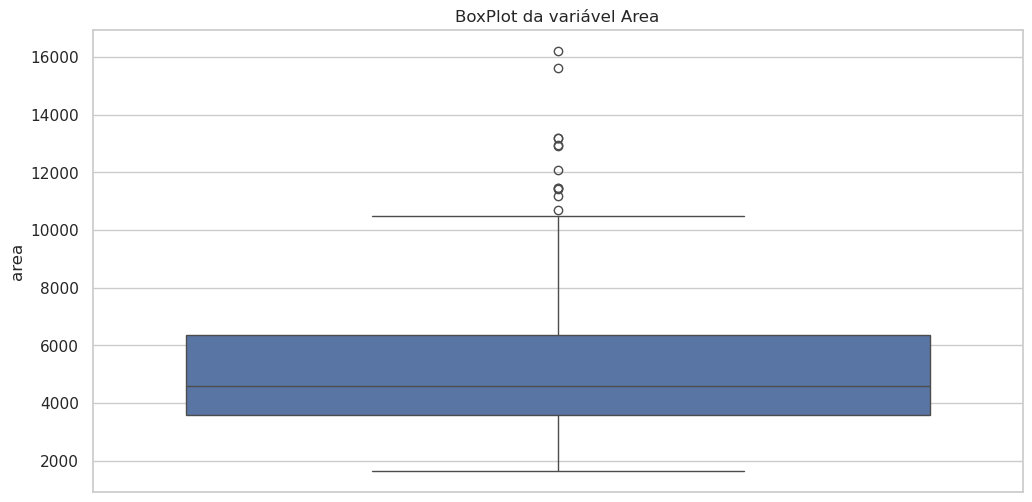

In [31]:
plt.figure(figsize=(12,6))
sns.boxplot(df_casas["area"])
plt.title("BoxPlot da variável Area")
plt.show()

### 5. Limpeza e Pré Processamento

In [32]:
df_casas.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

In [33]:
# Renomeando as colunas para português
colunas_pt = ["preco", "area", "quartos", "banheiros", "andares", "acesso_rodovia",
             "quarto_hospede", "porao", "aquecimento_agua", "ar_condicionado", "vagas_estacionamento", 
             "area_preferencial", "status_mobilia"]

In [34]:
colunas_df_pt = {coluna_df: coluna_br for coluna_df, coluna_br in zip(df_casas.columns, colunas_pt)} # dicionário para renomear as colunas

In [35]:
df_limpo = df_casas.rename(columns=colunas_df_pt) # novo df para o pré processamento (com as colunas em portugues)

In [36]:
# Tratanto outliers da variável preço
IC = df_limpo["preco"].quantile(0.75) - df_limpo["preco"].quantile(0.25) # tamanho da caixa do boxplot
formula_preco = df_limpo["preco"].quantile(0.75) + (1.5 * IC) # formula para encontrar valores extremos a partir do ponto máximo

In [37]:
# Visualizando os registros com outliers em preço
outliers_preco = df_limpo[df_limpo["preco"] > formula_preco]

In [38]:
outliers_preco

,preco,area,quartos,banheiros,andares,acesso_rodovia,quarto_hospede,porao,aquecimento_agua,ar_condicionado,vagas_estacionamento,area_preferencial,status_mobilia
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
5,10850000,7500,3,3,1,yes,no,yes,no,yes,2,yes,semi-furnished
6,10150000,8580,4,3,4,yes,no,no,no,yes,2,yes,semi-furnished
7,10150000,16200,5,3,2,yes,no,no,no,no,0,no,unfurnished
8,9870000,8100,4,1,2,yes,yes,yes,no,yes,2,yes,furnished
9,9800000,5750,3,2,4,yes,yes,no,no,yes,1,yes,unfurnished


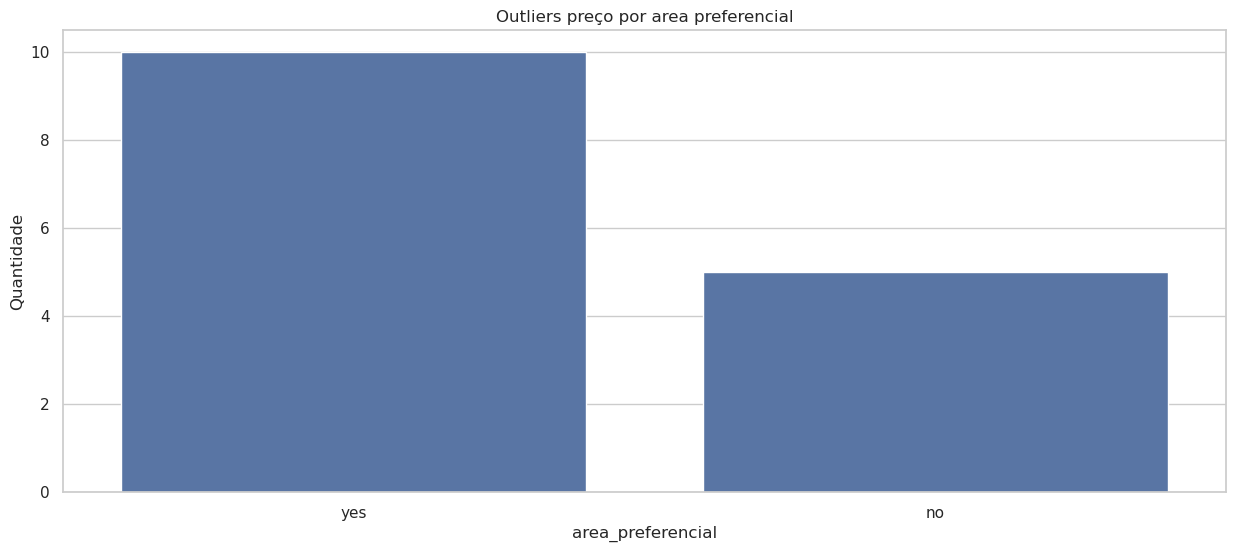

In [39]:
plt.figure(figsize=(15,6))
sns.countplot(data=outliers_preco, x="area_preferencial")
plt.ylabel("Quantidade")
plt.title("Outliers preço por area preferencial")
plt.show()

In [40]:
# Tratando outliers da variável area
# Antes disso vamos passar a area de pés quadrados para metros quadrados
df_limpo["area"] = df_limpo["area"] * 0.0929

In [41]:
IC2 = df_limpo["area"].quantile(0.75) - df_limpo["area"].quantile(0.25) # tamanho da caixa do boxplot
formula_area = df_limpo["area"].quantile(0.75) + (1.5 * IC2) # formula para encontrar valores extremos a partir do ponto máximo

In [42]:
outliers_area = df_limpo[df_limpo["area"] > formula_area]

In [43]:
outliers_area

,preco,area,quartos,banheiros,andares,acesso_rodovia,quarto_hospede,porao,aquecimento_agua,ar_condicionado,vagas_estacionamento,area_preferencial,status_mobilia
7,10150000,1504.9800,5,3,2,yes,no,no,no,no,0,no,unfurnished
10,9800000,1226.2800,3,1,2,yes,no,yes,no,yes,2,yes,furnished
56,7343000,1062.7760,4,1,2,yes,no,yes,no,no,1,yes,semi-furnished
64,7000000,1038.1575,3,1,1,yes,no,yes,no,yes,1,yes,furnished
66,6930000,1226.2800,2,1,1,yes,no,yes,yes,no,1,no,furnished
69,6790000,1123.1610,4,2,2,yes,no,no,no,no,2,yes,furnished
125,5943000,1449.2400,3,1,1,yes,no,no,no,yes,2,no,semi-furnished
129,5873000,1064.6340,3,1,3,yes,no,no,no,no,2,yes,semi-furnished
186,5110000,1059.9890,2,1,2,yes,no,no,no,no,0,yes,furnished
191,5040000,994.0300,3,1,2,yes,yes,yes,no,no,0,no,semi-furnished


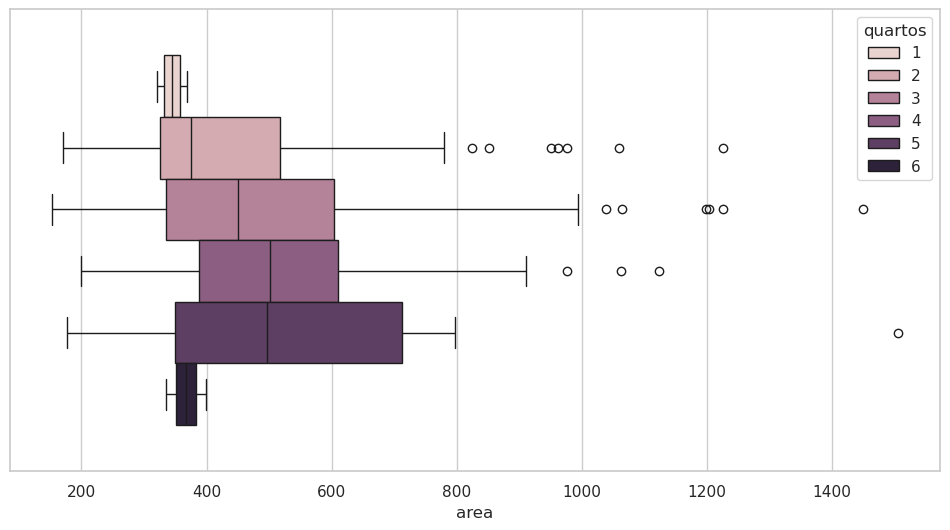

In [44]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_limpo,x="area", hue="quartos")
plt.show()

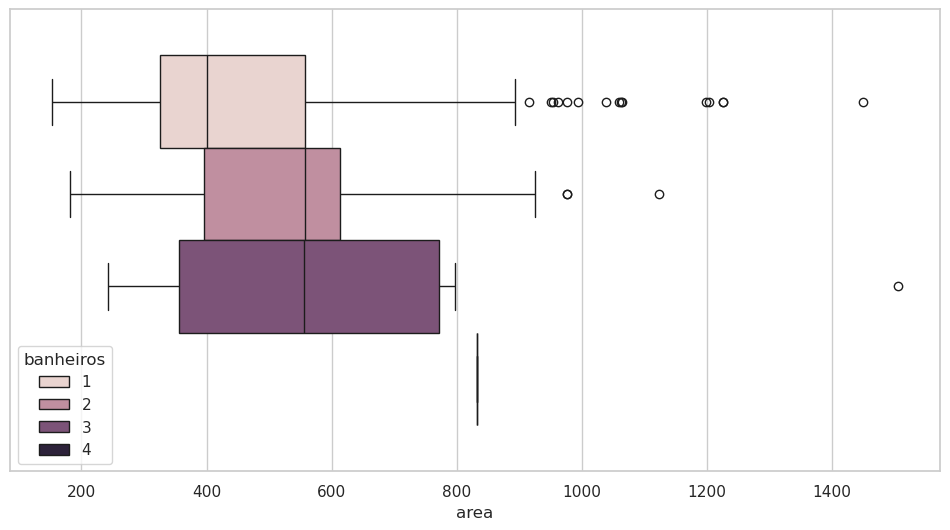

In [45]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_limpo,x="area", hue="banheiros")
plt.show()

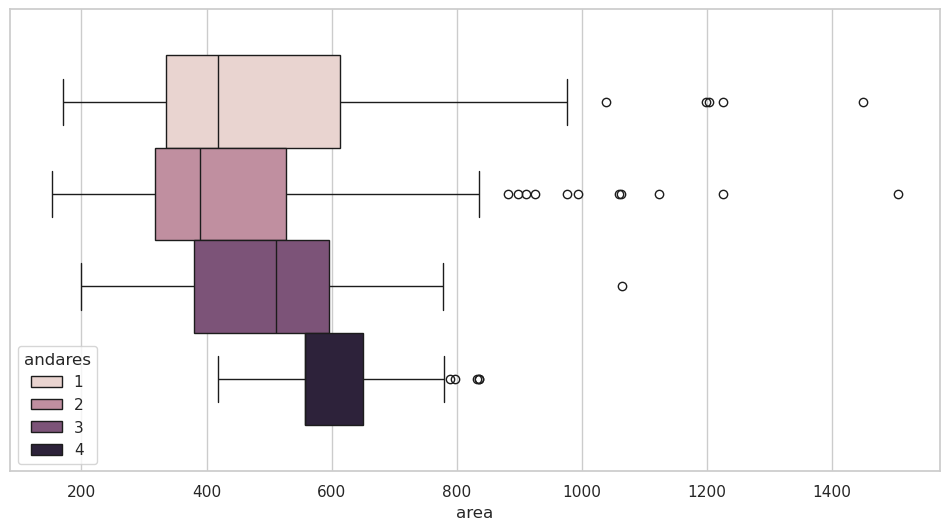

In [46]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_limpo,x="area", hue="andares")
plt.show()

In [47]:
df_limpo

,preco,area,quartos,banheiros,andares,acesso_rodovia,quarto_hospede,porao,aquecimento_agua,ar_condicionado,vagas_estacionamento,area_preferencial,status_mobilia
0,13300000,689.318,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,832.384,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,925.284,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,696.750,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,689.318,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,1855000,277.771,2,1,1,no,no,no,no,no,1,no,unfurnished
540,1820000,278.700,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,222.960,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,336.298,2,1,1,yes,no,no,no,no,0,no,unfurnished


In [48]:
mapeamento = {
    "no":0,
    "yes":1
}

In [49]:
for coluna in df_limpo.select_dtypes(include=["object"]).drop(columns="status_mobilia").columns:
    df_limpo[coluna] = df_limpo[coluna].map(mapeamento)

In [50]:
"""
Mapeamento de
0 = no
1 = yes

nas variáveis (acesso_rodovia, quarto_hospede, porao, aquecimento_agua,
       ar_condicionado, area_preferencial)
"""
df_limpo # depois do mapeamento

,preco,area,quartos,banheiros,andares,acesso_rodovia,quarto_hospede,porao,aquecimento_agua,ar_condicionado,vagas_estacionamento,area_preferencial,status_mobilia
0,13300000,689.318,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,832.384,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,925.284,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,696.750,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,689.318,4,1,2,1,1,1,0,1,2,0,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,1855000,277.771,2,1,1,0,0,0,0,0,1,0,unfurnished
540,1820000,278.700,2,1,1,1,0,1,0,0,2,0,unfurnished
541,1767150,222.960,3,1,1,0,0,0,0,0,0,0,semi-furnished
542,1750000,336.298,2,1,1,1,0,0,0,0,0,0,unfurnished


In [51]:
# Agora vamos mapear a variável status_mobilia para passar pro portugues
mapeamento_mobilia = {
    "furnished":"mobiliada",
    "semi-furnished":"semi-mobiliada",
    "unfurnished":"sem-mobilia"
}

In [52]:
df_limpo["status_mobilia"] = df_limpo["status_mobilia"].map(mapeamento_mobilia)

In [53]:
df_limpo

,preco,area,quartos,banheiros,andares,acesso_rodovia,quarto_hospede,porao,aquecimento_agua,ar_condicionado,vagas_estacionamento,area_preferencial,status_mobilia
0,13300000,689.318,4,2,3,1,0,0,0,1,2,1,mobiliada
1,12250000,832.384,4,4,4,1,0,0,0,1,3,0,mobiliada
2,12250000,925.284,3,2,2,1,0,1,0,0,2,1,semi-mobiliada
3,12215000,696.750,4,2,2,1,0,1,0,1,3,1,mobiliada
4,11410000,689.318,4,1,2,1,1,1,0,1,2,0,mobiliada
...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,1855000,277.771,2,1,1,0,0,0,0,0,1,0,sem-mobilia
540,1820000,278.700,2,1,1,1,0,1,0,0,2,0,sem-mobilia
541,1767150,222.960,3,1,1,0,0,0,0,0,0,0,semi-mobiliada
542,1750000,336.298,2,1,1,1,0,0,0,0,0,0,sem-mobilia


In [54]:
df_limpo = pd.get_dummies(df_limpo, columns=["status_mobilia"], dtype=int)

In [55]:
df_limpo

,preco,area,quartos,banheiros,andares,acesso_rodovia,quarto_hospede,porao,aquecimento_agua,ar_condicionado,vagas_estacionamento,area_preferencial,status_mobilia_mobiliada,status_mobilia_sem-mobilia,status_mobilia_semi-mobiliada
0,13300000,689.318,4,2,3,1,0,0,0,1,2,1,1,0,0
1,12250000,832.384,4,4,4,1,0,0,0,1,3,0,1,0,0
2,12250000,925.284,3,2,2,1,0,1,0,0,2,1,0,0,1
3,12215000,696.750,4,2,2,1,0,1,0,1,3,1,1,0,0
4,11410000,689.318,4,1,2,1,1,1,0,1,2,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,1855000,277.771,2,1,1,0,0,0,0,0,1,0,0,1,0
540,1820000,278.700,2,1,1,1,0,1,0,0,2,0,0,1,0
541,1767150,222.960,3,1,1,0,0,0,0,0,0,0,0,0,1
542,1750000,336.298,2,1,1,1,0,0,0,0,0,0,0,1,0


In [56]:
df_limpo.dtypes

preco                              int64
area                             float64
quartos                            int64
banheiros                          int64
andares                            int64
acesso_rodovia                     int64
quarto_hospede                     int64
porao                              int64
aquecimento_agua                   int64
ar_condicionado                    int64
vagas_estacionamento               int64
area_preferencial                  int64
status_mobilia_mobiliada           int64
status_mobilia_sem-mobilia         int64
status_mobilia_semi-mobiliada      int64
dtype: object

In [57]:
colunas_nao_binarias = ["preco", "area", "quartos", "banheiros",
       "andares", "vagas_estacionamento"]

In [58]:
normalizar = MinMaxScaler()
normalizar.fit(df_limpo[colunas_nao_binarias])
colunas_normalizadas = pd.DataFrame(data=normalizar.transform(df_limpo[colunas_nao_binarias]), 
                                    columns=df_limpo[colunas_nao_binarias].columns)

In [59]:
colunas_normalizadas # Dados normalizados

,preco,area,quartos,banheiros,andares,vagas_estacionamento
0,1.000000,0.396564,0.6,0.333333,0.666667,0.666667
1,0.909091,0.502405,0.6,1.000000,1.000000,1.000000
2,0.909091,0.571134,0.4,0.333333,0.333333,0.666667
3,0.906061,0.402062,0.6,0.333333,0.333333,1.000000
4,0.836364,0.396564,0.6,0.000000,0.333333,0.666667
...,...,...,...,...,...,...
537,0.009091,0.092096,0.2,0.000000,0.000000,0.333333
538,0.006061,0.092784,0.2,0.000000,0.000000,0.666667
539,0.001485,0.051546,0.4,0.000000,0.000000,0.000000
540,0.000000,0.135395,0.2,0.000000,0.000000,0.000000


In [60]:
round(colunas_normalizadas.describe(),2) # Minimo 0 e Máximo 1

,preco,area,quartos,banheiros,andares,vagas_estacionamento
count,542.00,542.00,542.00,542.00,542.00,542.00
mean,0.26,0.24,0.39,0.10,0.27,0.23
std,0.16,0.15,0.15,0.17,0.29,0.29
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.15,0.13,0.25,0.00,0.00,0.00
50%,0.22,0.20,0.40,0.00,0.33,0.00
75%,0.35,0.32,0.40,0.33,0.33,0.33
max,1.00,1.00,1.00,1.00,1.00,1.00


In [61]:
padronizar = StandardScaler()
padronizar.fit(df_limpo[colunas_nao_binarias])
colunas_padronizadas = pd.DataFrame(data=padronizar.transform(df_limpo[colunas_nao_binarias]), 
                                    columns=df_limpo[colunas_nao_binarias].columns)

In [62]:
colunas_padronizadas # Dados padronizados

,preco,area,quartos,banheiros,andares,vagas_estacionamento
0,4.564410,1.041563,1.399246,1.416020,1.373660,1.511781
1,4.002058,1.750626,1.399246,5.392617,2.526173,2.672383
2,4.002058,2.211056,0.042553,1.416020,0.221146,1.511781
3,3.983313,1.078397,1.399246,1.416020,0.221146,2.672383
4,3.552177,1.041563,1.399246,-0.572278,0.221146,1.511781
...,...,...,...,...,...,...
537,-1.565221,-0.998145,-1.314140,-0.572278,-0.931367,0.351179
538,-1.583966,-0.993540,-1.314140,-0.572278,-0.931367,1.511781
539,-1.612271,-1.269799,0.042553,-0.572278,-0.931367,-0.809424
540,-1.621457,-0.708073,-1.314140,-0.572278,-0.931367,-0.809424


In [63]:
round(colunas_padronizadas.describe(),2) # Média 0 e Desvio Padrão 1

,preco,area,quartos,banheiros,andares,vagas_estacionamento
count,542.00,542.00,542.00,542.00,542.00,542.00
mean,-0.00,-0.00,-0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.62,-1.62,-2.67,-0.57,-0.93,-0.81
25%,-0.70,-0.72,-0.97,-0.57,-0.93,-0.81
50%,-0.23,-0.26,0.04,-0.57,0.22,-0.81
75%,0.53,0.55,0.04,1.42,0.22,0.35
max,4.56,5.08,4.11,5.39,2.53,2.67


In [64]:
# Dataframe limpo e normalizado
df_limpo_normalizado = pd.concat([colunas_normalizadas, 
                                  df_limpo.drop(columns=colunas_normalizadas.columns).reset_index(drop=True)], axis=1)

In [65]:
df_limpo_normalizado.head()

,preco,area,quartos,banheiros,andares,vagas_estacionamento,acesso_rodovia,quarto_hospede,porao,aquecimento_agua,ar_condicionado,area_preferencial,status_mobilia_mobiliada,status_mobilia_sem-mobilia,status_mobilia_semi-mobiliada
0,1.000000,0.396564,0.6,0.333333,0.666667,0.666667,1,0,0,0,1,1,1,0,0
1,0.909091,0.502405,0.6,1.000000,1.000000,1.000000,1,0,0,0,1,0,1,0,0
2,0.909091,0.571134,0.4,0.333333,0.333333,0.666667,1,0,1,0,0,1,0,0,1
3,0.906061,0.402062,0.6,0.333333,0.333333,1.000000,1,0,1,0,1,1,1,0,0
4,0.836364,0.396564,0.6,0.000000,0.333333,0.666667,1,1,1,0,1,0,1,0,0


In [66]:
# Dataframe limpo e padronizado
df_limpo_padronizado = pd.concat([colunas_padronizadas, 
                                  df_limpo.drop(columns=colunas_padronizadas.columns).reset_index(drop=True)], axis=1)

In [67]:
df_limpo_padronizado.head()

,preco,area,quartos,banheiros,andares,vagas_estacionamento,acesso_rodovia,quarto_hospede,porao,aquecimento_agua,ar_condicionado,area_preferencial,status_mobilia_mobiliada,status_mobilia_sem-mobilia,status_mobilia_semi-mobiliada
0,4.564410,1.041563,1.399246,1.416020,1.373660,1.511781,1,0,0,0,1,1,1,0,0
1,4.002058,1.750626,1.399246,5.392617,2.526173,2.672383,1,0,0,0,1,0,1,0,0
2,4.002058,2.211056,0.042553,1.416020,0.221146,1.511781,1,0,1,0,0,1,0,0,1
3,3.983313,1.078397,1.399246,1.416020,0.221146,2.672383,1,0,1,0,1,1,1,0,0
4,3.552177,1.041563,1.399246,-0.572278,0.221146,1.511781,1,1,1,0,1,0,1,0,0


### 6. Modelo

In [68]:
for coluna in df_casas.select_dtypes(include=np.number):
    teste = shapiro(df_casas[coluna])
    if teste.pvalue > 0.05:
        print(f"Nossa variável {coluna} assume uma distribuição normal")
    else:
        print(f"Nossa variável {coluna} não assume uma distribuição normal")

Nossa variável price não assume uma distribuição normal
Nossa variável area não assume uma distribuição normal
Nossa variável bedrooms não assume uma distribuição normal
Nossa variável bathrooms não assume uma distribuição normal
Nossa variável stories não assume uma distribuição normal
Nossa variável parking não assume uma distribuição normal


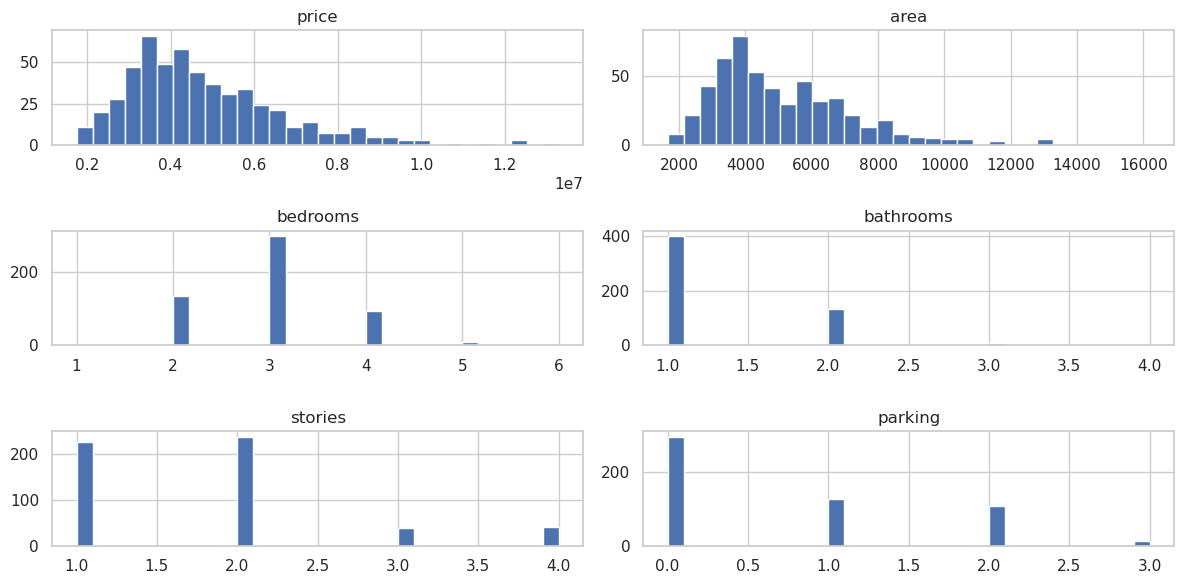

In [69]:
df_casas.hist(bins=30, figsize=(12,6))
plt.tight_layout()
plt.show()

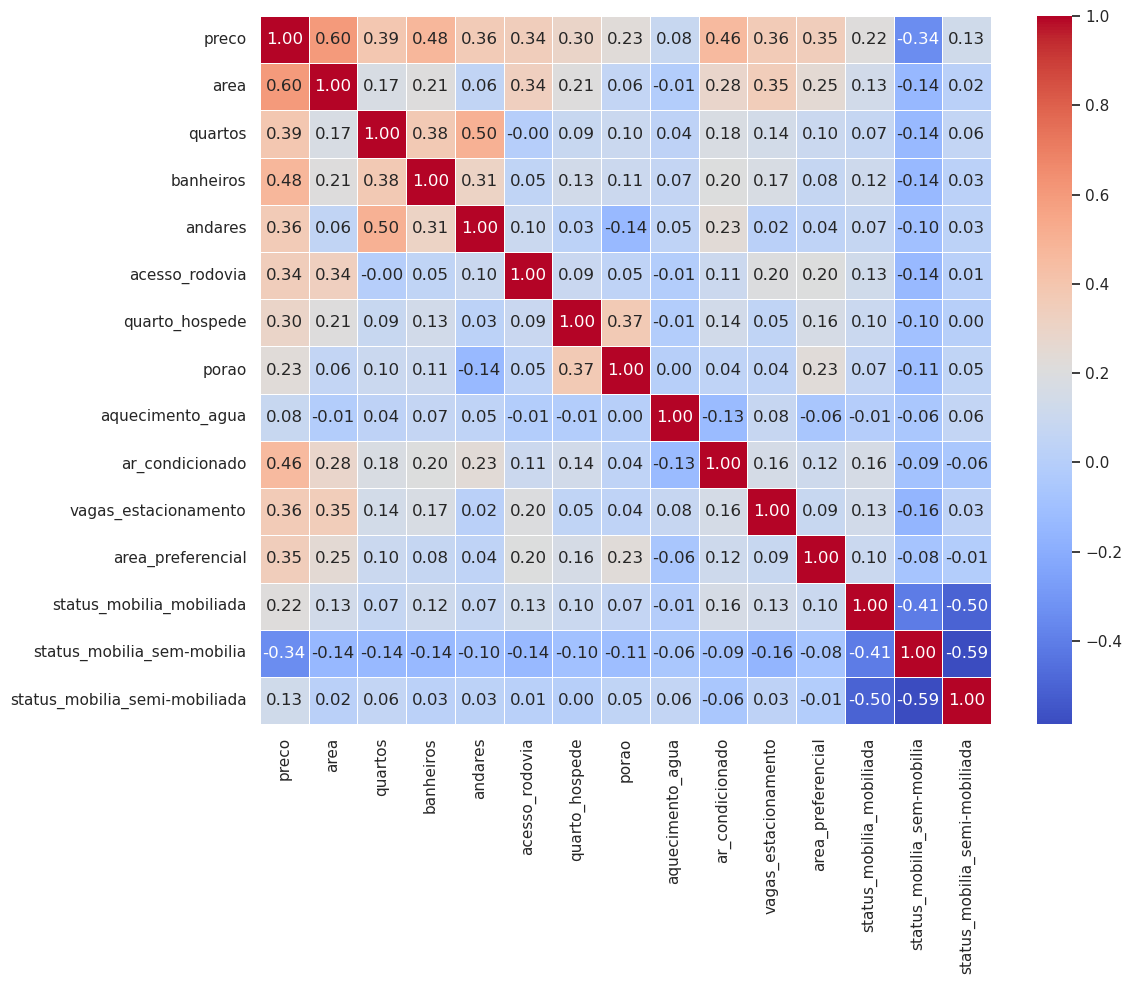

In [70]:
corr_matrix = df_limpo.corr(method="spearman")

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.tight_layout()
plt.show()

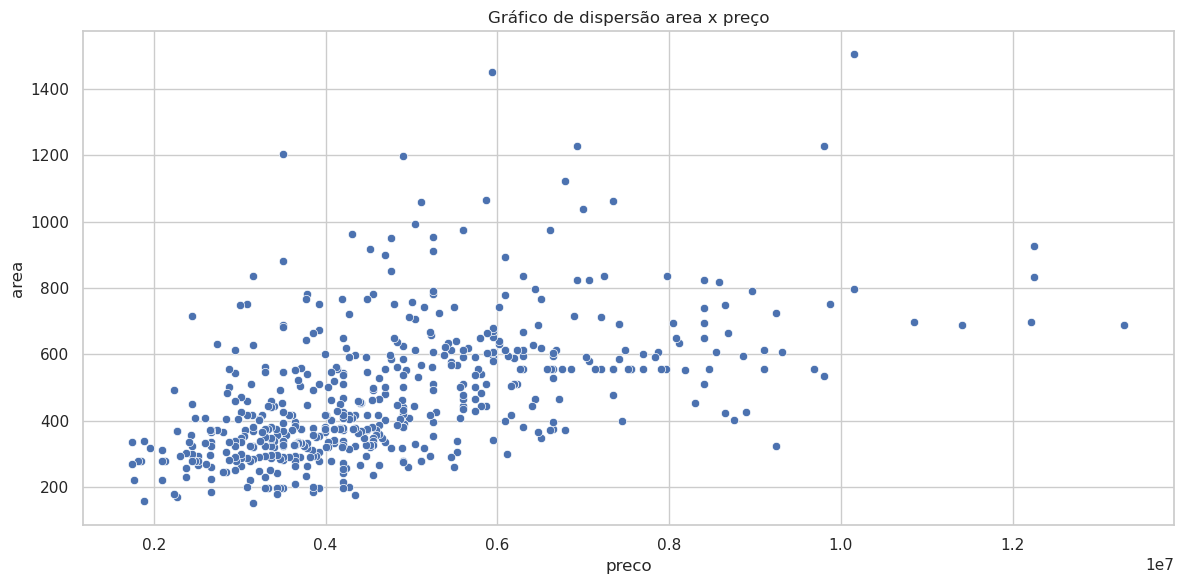

In [71]:
plt.figure(figsize=(12,6))
sns.scatterplot(x=df_limpo["preco"],y= df_limpo["area"])
plt.title("Gráfico de dispersão area x preço")
plt.tight_layout()
plt.show()

In [72]:
# Dividindo conjunto de treino e teste
X = df_limpo_padronizado.drop(columns="preco").values
Y = df_limpo_padronizado["preco"].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=7)

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(460, 14)
(460,)
(82, 14)
(82,)


In [73]:
# Algoritmos de regressão
models_linear = []
models_linear.append(("Regressão Linear", LinearRegression()))
models_linear.append(("SVR Linear", SVR(kernel="linear")))

In [74]:
kfold = KFold(n_splits=5, shuffle=True, random_state=7) # Criando o Kfold

In [75]:
results = []
for name, model in models_linear:
    results.append(cross_val_score(model, X_train, Y_train, cv=kfold, 
                               scoring="r2"))